<a href="https://colab.research.google.com/github/dillonkoh89/GA-Capstone/blob/main/Capstone_Part_2_Object_Detection_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Capstone Project: Reducing Workplace Injuries in Singapore using Objection Detection Model

# Dillon Koh, DSIF-2 Singapore

## Problem Statement

Recently in 29th July 2021, a Straits Times article on Workplace inuries, fatalities can hinder business's recovery from Covid-19 pandemic was published. Manpower Minister Tan See Leng highlighted that employers and employees need to step up their workplace safety and health efforts as injuries and fatalities can hinder business recovery from the Covid-19 pandemic. He stressed that companies must continue their workplace safety and health efforts amid the pandemic, on top of the safe management measures to limit interactions at workplaces and prevent the spread of Covid-19 among workers.

In Workplace Safety and Health Report 2020 - National Statistics by Ministry of Manpower, it was mentioned that the top three causes of workpace minor injuries were:
-  (i) Slips, Trips & Falls
- (ii) Machinery Incidents; and
- (iii) Struck by Moving Objects.

These collectively accounted for 55% (5,993 cases) of the total number of workplace minor injuries in year 2020.

Hence, I would like to make use of Deep Learning to reduce the number of workplace injuries in Singapore. 

The overall end goal of my projet is to reduce the number of workplace injuries by using Object Detection Model to detect if any workers are not wearing PPE (Helmet and Vest) properly inside a PPE zone and Sounding off an alarm to alert the workers on the infringement using real time monitoring by cameras. However, the scope of my GA capstone will only cover the Object Detection Model aspect.

## Target Audence 
Various Stakeholders such as Worksite Contractors / Companies, Ministry of Manpower and etc

## Datasets of Images 
- Kaggle
- Google Images

# Object Detection using EfficientDet-Lite0 Model
In this second notebook of my Capstone Project, I will train a custom object detection model using Tensorflow Lite Model Maker Library (TF API) leveraging on transfer learning with EfficientDet-Lite0 model. EfficientDet-Lite[0-4] are a family of mobile/IoT-friendly object detection models derived from the EfficientDet architecture.

Here is the performance of each EfficientDet-Lite models compared to each others.

| Model architecture | Size(MB)* | Latency(ms)** | Average Precision*** |
| :----------------- | :-------- | :------------ | :------------------- |
| EfficientDet-Lite0 | 4.4       | 37            | 25.69%               |
| EfficientDet-Lite1 | 5.8       | 49            | 30.55%               |
| EfficientDet-Lite2 | 7.2       | 69            | 33.97%               |
| EfficientDet-Lite3 | 11.4      | 116           | 37.70%               |
| EfficientDet-Lite4 | 19.9      | 260           | 41.96%               |
* Size of the integer quantized models.
** Latency measured on Pixel 4 using 4 threads on CPU.
*** Average Precision is the mAP (mean Average Precision) on the COCO 2017 validation dataset.

The EfficientDet architect employs EfficientNet as the backbone network, BiFPN as the feature network and the architecture can be shown in the figure below.
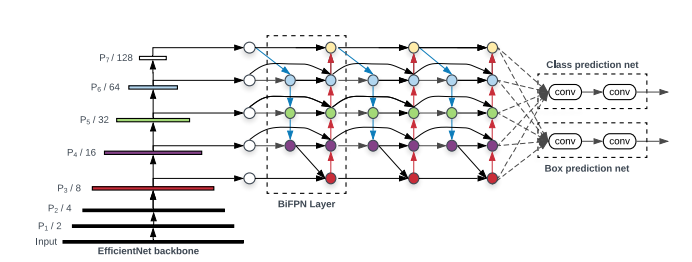

The two main contributions of the EfficientDet architecture were:
1. BiFPN (Bi-directional Feature Pyramid Network)
2. Compound Scaling
BiFPN is a type of feature pyramid network which allows easy and fast multi-scale feature fusion and compound scaling basically means scaling up all dimensions (depth, channels, image size) while maintaining a balance between all dimensions of the network

# Preparing the images

Before training my object detection model, I have to prepared the images and annotations to train my object detection model. As mentioned in the above, I have images downloaded from both Kaggle and Google. They consists of images of people, safety vests and helmets. I will then use LabelImg which is a grahpical image annotation tool which is written in Python and ues Qt for its graphical interface to draw bounding boxes on safety vests, person and helmets in all my images. The annotation will then be saved as XML files in PASCAL VOC format which is compatible to the Tensorflow Lite Model Maker Library. 

An example of the annotated images is shown in the figure below.
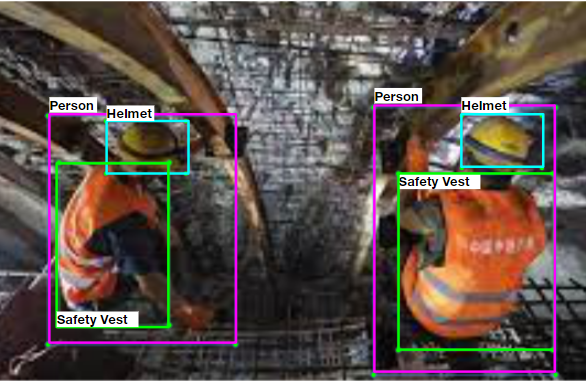

Upon completion of the annotation of all images, i then proceed to split my images an respective annotations into 3 different groups -
* Training Images - 70%
* Validation Images - 20%
* Test Images - 10%

The training images will be used to train the object detection model to recognize helmets, safety vests and persons. The validation images are images that the model didnt see during the training process and will be used in hyperparameter tuning and stop the training. Finally, the test images will be used to evaluate the performance of the model as new data it has never seen before.

Also, for several images, I have also used an image augmentation tool to perform a specific set of augmentation operations on each file that it finds. Some operations include horizontal and vertical flips, rotation, translation, zoom/stretch and blurring the images.

# Approach to training the Object Detection Model
Before training the custom Object Detection Model with entire dataset (total of 1,213 images), I will use 10% of my images to ensure that our smaller modelling experiments are working. This is a common practice in machine learning and deep learning: get a model working on a small amount of data before scaling it up to a larger amount of data

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/06-ml-serial-experimentation.png)
*Machine learning practitioners are serial experimenters. Start small, get a model working, see if your experiments work then gradually scale them up to where you want to go.* Source: https://colab.research.google.com/drive/1vBR85tR5_yS88ZhKf2XfzKKKKAoqhLou?usp=sharing#scrollTo=UTWetPM7AWfY

After confirming that the model with 10% images is completed with no problems. I will then train my model with the entire datasets.

I trained a model with 50 epoch and 25 epochs and evaluated the results of their performance. Subsequently, I also export the models to a tflite model and evaluate the performance after exporting. The main reason is there will be several factors that can affect the model accuracy when exporting to TFLite:
* Quantization helps shrinking the model size by 4 times at the expense of some accuracy drop.
* The original TensorFlow model uses per-class non-max supression (NMS) for post-processing, while the TFLite model uses global NMS that's much faster but less accurate. Keras outputs maximum 100 detections while tflite outputs maximum 25 detections.

Therefore I'll have to evaluate the exported TFLite model and compare its accuracy with the original TensorFlow model.

# Evaluation Metrics and Summary of Results
After training the model, I will be evaluating the test data of both models which are trainined with 50 and 25 epochs considering the mean average precision (mAP) of the test datasets. The library computes the mAP which is the detection evaluation metrics use by Common Objects in Context (COCO). In fact, there are 15 metrics that used for characterizing the performance of an object detector on COCO and be found in the following link - https://cocodataset.org/#detection-eval.

However, for my project I will only consider the following 3 mAPs of the test instead of the other metrics:
* mAP (at IoU=50:.05:.95) - Uses 10 IoU thresholds of 0.50 to 0.95 with step of 0.05 and average the AP across the different thresholds [More Stringent]
* mAP (at IoU=50) - Consider the AP at IoU of 0.50 [Traditional Method]
* mAP (at IoU=0.75) Consider the AP at IoU of 0.75 [In between the above 2]

The reason is mAP is a popular metric in measuring the accuracy of object detection model. 

In addition, I will actually do a manual evaluation of my chosen model by doing some error analysis running through the predicted bounding boxes on all my test images and evaluating the model performance. More details will be shared in Capstone Part 3 notebook.

For the selection of the model, I will purely use the 3 mAPs described above.

## Model results
The following table summarizes the mAPs scores 

| Model                                      | mAP            | mAP Score |
| :----------------------------------------- | :------------- | :-------- |
| Model with 50 epochs (Before Quantization) | IoU=50:.05:.95 | 0.613     |
|                                            | IoU=50         | 0.914     |
|                                            | IoU=0.75       | 0.713     |
| Model with 50 epochs (After Quantization)  | IoU=50:.05:.95 | 0.582     |
|                                            | IoU=50         | 0.880     |
|                                            | IoU=0.75       | 0.674     |
| Model with 25 epochs (Before Quantization) | IoU=50:.05:.95 | 0.593     |
|                                            | IoU=50         | 0.905     |
|                                            | IoU=0.75       | 0.679     |
| Model with 25 epochs (After Quantization)  | IoU=50:.05:.95 | 0.566     |
|                                            | IoU=50         | 0.889     |
|                                            | IoU=0.75       | 0.630     |

Based on the scores, the model with 50 epochs perform better and hence I will use the tflite model as my chosen object detection model.

# Final Steps
After chosing my object detection model, I run the model on several images to see the results and the initital results seem to be quite good. More analysis will be carried out in Capstone Part 3 notebook. I then zip my work with the model into 1 folder so that I can download it and use the model in the third notebook.

# References
- https://www.mom.gov.sg/-/media/mom/documents/safety-health/reports-stats/wsh-national-statistics/wsh-national-stats-2020.pdf
- https://www.straitstimes.com/singapore/jobs/workplace-injuries-fatalities-can-hinder-business-recovery-from-covid-19-pandemic-tan
- https://www.kaggle.com/johnsyin97/hardhat-and-safety-vest-image-for-object-detection
- https://amaarora.github.io/2021/01/11/efficientdet.html
- https://amaarora.github.io/2020/08/13/efficientnet.html
- https://blog.paperspace.com/mean-average-precision/
- https://towardsdatascience.com/breaking-down-mean-average-precision-map-ae462f623a52
- https://github.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/blob/master/TFLite_detection_video.py
- https://dzone.com/articles/how-to-use-google-colaboratory-for-video-processin
- https://github.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi
- https://www.tensorflow.org/lite/tutorials/model_maker_object_detection
- https://arxiv.org/abs/1911.09070
- https://github.com/tzutalin/labelImg
- https://cocodataset.org/#detection-eval
- https://www.tensorflow.org/lite/tutorials/model_maker_object_detection
- https://www.tensorflow.org/lite/performance/post_training_quantization

In [ ]:
#pip install -q tensorflow==2.4.3
!pip install -q tflite-model-maker
!pip install -q pycocotools

     |████████████████████████████████| 616 kB 12.2 MB/s 
     |████████████████████████████████| 213 kB 50.6 MB/s 
     |████████████████████████████████| 1.1 MB 36.8 MB/s 
     |████████████████████████████████| 596 kB 42.7 MB/s 
     |████████████████████████████████| 1.1 MB 50.5 MB/s 
     |████████████████████████████████| 120 kB 51.4 MB/s 
     |████████████████████████████████| 3.4 MB 39.3 MB/s 
     |████████████████████████████████| 840 kB 45.4 MB/s 
     |████████████████████████████████| 87 kB 6.4 MB/s 
     |████████████████████████████████| 1.2 MB 38.4 MB/s 
     |████████████████████████████████| 77 kB 6.4 MB/s 
     |████████████████████████████████| 6.3 MB 26.7 MB/s 
     |████████████████████████████████| 25.3 MB 2.0 MB/s 
     |████████████████████████████████| 99 kB 9.6 MB/s 
     |████████████████████████████████| 47.6 MB 98 kB/s 
     |████████████████████████████████| 352 kB 25.1 MB/s 
     |████████████████████████████████| 208 kB 49.2 MB/s 


In [ ]:
# Importing the libraries
import numpy as np
import os
import zipfile
import os
import cv2

from PIL import Image
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

# Downloading the processed images

In [ ]:
# This cell is using google drive as storage for the dataset
# mount drive
# from google.colab import drive
# drive.mount('/content/drive/')

# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
# !ln -s /content/drive/My\ Drive/ /mydrive

#list contents in your drive
# !ls /mydrive

In [ ]:
# downloading zipped datasets from dropbox
#!wget https://www.dropbox.com/s/d0ckza4vnh820p8/TFlite.zip #This is the old folder with just dataset of images before the below modelling is completed. This folder is removed due to dropbox size capacity
!wget https://www.dropbox.com/s/fxmoldrklrfhtui/TFlite.zip

--2021-12-09 15:42:21--  https://www.dropbox.com/s/fxmoldrklrfhtui/TFlite.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.68.18, 2620:100:6023:18::a27d:4312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.68.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/fxmoldrklrfhtui/TFlite.zip [following]
--2021-12-09 15:42:22--  https://www.dropbox.com/s/raw/fxmoldrklrfhtui/TFlite.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc048578ab28a34d392cc98bea15.dl.dropboxusercontent.com/cd/0/inline/BbgJFHM-h8CQAhJaBbMnOPRN2QvgjQD9zK0qgr8mN8OUq03NE_L4pr3mCEFFn-5DphXxrAlNi87FMCCVQdRU6CpMpbvpnT4gp0u2440H7uCS-rCVua6NZzat3ABadXb9_MVA8hYK1t1Oy4LKZCZOPAFv/file# [following]
--2021-12-09 15:42:22--  https://uc048578ab28a34d392cc98bea15.dl.dropboxusercontent.com/cd/0/inline/BbgJFHM-h8CQAhJaBbMnOPRN2QvgjQD9zK0qgr8mN8OUq03NE_L4pr3mCEFFn-5DphXxrAlNi87FMCCVQdRU6CpMpbvpn

In [ ]:
#extracting the files in the downloaded classification.zip file
zip_ref = zipfile.ZipFile("TFlite.zip")
#Extracts the files into the folder
zip_ref.extractall() 
zip_ref.close()

# Training Model with 10 percent of data

In [ ]:
%cd TFlite/
# Walk through the "10percent" data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

/content/TFlite
There are 3 directories and 0 images in '10percent'.
There are 2 directories and 0 images in '10percent/val'.
There are 0 directories and 16 images in '10percent/val/images'.
There are 0 directories and 16 images in '10percent/val/annotations'.
There are 2 directories and 0 images in '10percent/test'.
There are 1 directories and 5 images in '10percent/test/images'.
There are 0 directories and 0 images in '10percent/test/images/.ipynb_checkpoints'.
There are 0 directories and 4 images in '10percent/test/annotations'.
There are 2 directories and 0 images in '10percent/train'.
There are 0 directories and 80 images in '10percent/train/images'.
There are 0 directories and 80 images in '10percent/train/annotations'.


In [ ]:
# This cell is for walking the data directory when using google drive

# %cd /mydrive/TFlite
# Walk through the "10percent" data directory and list number of files
# for dirpath, dirnames, filenames in os.walk("10percent"):
#  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")



In [ ]:
#spec = model_spec.get('efficientdet_lite0')
spec = object_detector.EfficientDetLite0Spec(model_dir='log')

In [ ]:
#setting the path for creating the data using google drive
# train_image_dir = '/mydrive/TFlite/10percent/train/images'
# train_annot_dir = '/mydrive/TFlite/10percent/train/annotations'

# test_image_dir = '/mydrive/TFlite/10percent/test/images'
# test_annot_dir = '/mydrive/TFlite/10percent/test/annotations'

# val_image_dir = '/mydrive/TFlite/10percent/val/images'
# val_annot_dir = '/mydrive/TFlite/10percent/val/annotations'

#creating the train and test data 
# train_data = object_detector.DataLoader.from_pascal_voc(train_image_dir, train_annot_dir, label_map={1: "helmet", 2: "person", 3: 'safety vest'})
# test_data = object_detector.DataLoader.from_pascal_voc(test_image_dir, test_annot_dir, label_map={1: "helmet", 2: "person", 3: 'safety vest'})
# val_data = object_detector.DataLoader.from_pascal_voc(val_image_dir, val_annot_dir, label_map={1: "helmet", 2: "person", 3: 'safety vest'})

In [ ]:
#setting the path for creating the data using dropbox
train_image_dir = '/content/TFlite/10percent/train/images'
train_annot_dir = '/content/TFlite/10percent/train/annotations'

test_image_dir = '/content/TFlite/10percent/test/images'
test_annot_dir = '/content/TFlite/10percent/test/annotations'

val_image_dir = '/content/TFlite/10percent/val/images'
val_annot_dir = '/content/TFlite/10percent/val/annotations'

#creating the train and test data 
train_data = object_detector.DataLoader.from_pascal_voc(train_image_dir, train_annot_dir, label_map={1: "helmet", 2: "person", 3: 'safety vest'})
test_data = object_detector.DataLoader.from_pascal_voc(test_image_dir, test_annot_dir, label_map={1: "helmet", 2: "person", 3: 'safety vest'})
val_data = object_detector.DataLoader.from_pascal_voc(val_image_dir, val_annot_dir, label_map={1: "helmet", 2: "person", 3: 'safety vest'})

In [ ]:
# training the model
model = object_detector.create(train_data, model_spec=spec, epochs=50, batch_size=8, train_whole_model=True, validation_data=val_data)

Epoch 1/50
10/10 [==============================] - 57s 1s/step - det_loss: 1.8009 - cls_loss: 1.1416 - box_loss: 0.0132 - reg_l2_loss: 0.0632 - loss: 1.8641 - learning_rate: 0.0090 - gradient_norm: 0.8784 - val_det_loss: 1.7837 - val_cls_loss: 1.1224 - val_box_loss: 0.0132 - val_reg_l2_loss: 0.0632 - val_loss: 1.8469
Epoch 2/50
10/10 [==============================] - 7s 678ms/step - det_loss: 1.6999 - cls_loss: 1.1136 - box_loss: 0.0117 - reg_l2_loss: 0.0632 - loss: 1.7631 - learning_rate: 0.0100 - gradient_norm: 1.0078 - val_det_loss: 1.6988 - val_cls_loss: 1.0777 - val_box_loss: 0.0124 - val_reg_l2_loss: 0.0632 - val_loss: 1.7620
Epoch 3/50
10/10 [==============================] - 6s 675ms/step - det_loss: 1.6069 - cls_loss: 1.0591 - box_loss: 0.0110 - reg_l2_loss: 0.0632 - loss: 1.6701 - learning_rate: 0.0099 - gradient_norm: 1.0193 - val_det_loss: 1.5735 - val_cls_loss: 0.9788 - val_box_loss: 0.0119 - val_reg_l2_loss: 0.0632 - val_loss: 1.6366
Epoch 4/50
10/10 [==================

In [ ]:
# Using the model on train data and evaluating
model.evaluate(train_data)

2/2 [==============================] - 20s 5s/step



{'AP': 0.5574368,
 'AP50': 0.8964272,
 'AP75': 0.63920957,
 'AP_/helmet': 0.44896936,
 'AP_/person': 0.61699396,
 'AP_/safety vest': 0.6063472,
 'APl': 0.7209888,
 'APm': 0.5449054,
 'APs': 0.34968752,
 'ARl': 0.79845893,
 'ARm': 0.6332371,
 'ARmax1': 0.31056806,
 'ARmax10': 0.6300898,
 'ARmax100': 0.6516585,
 'ARs': 0.5004065}

In [ ]:
# Using the model on val data and evaluating
model.evaluate(val_data)

1/1 [==============================] - 5s 5s/step



{'AP': 0.29116282,
 'AP50': 0.66848826,
 'AP75': 0.20636266,
 'AP_/helmet': 0.15539056,
 'AP_/person': 0.38744202,
 'AP_/safety vest': 0.33065593,
 'APl': 0.26342314,
 'APm': 0.39894664,
 'APs': 0.13846946,
 'ARl': 0.34583333,
 'ARm': 0.5511239,
 'ARmax1': 0.091400295,
 'ARmax10': 0.38543412,
 'ARmax100': 0.41336238,
 'ARs': 0.24549733}

In [ ]:
# Using the model on test data and evaluating
model.evaluate(test_data)

1/1 [==============================] - 4s 4s/step



{'AP': 0.38792786,
 'AP50': 0.77499473,
 'AP75': 0.3645851,
 'AP_/helmet': 0.19165663,
 'AP_/person': 0.5539079,
 'AP_/safety vest': 0.41821906,
 'APl': -1.0,
 'APm': 0.5419522,
 'APs': 0.27756,
 'ARl': -1.0,
 'ARm': 0.6403509,
 'ARmax1': 0.1337232,
 'ARmax10': 0.42865497,
 'ARmax100': 0.47475633,
 'ARs': 0.33555555}

In [ ]:
# export saved model folder and labels.txt
model.export(export_dir='/content/TFlite/colab_models/tflite1/', export_format=[ExportFormat.SAVED_MODEL, ExportFormat.LABEL])

In [ ]:
# export model.tflite
model.export(export_dir='/content/TFlite/colab_models/tflite2/')

In [ ]:
# evaluate the test data using the tflite model after quantization
model.evaluate_tflite('/content/TFlite/colab_models/tflite2/model.tflite', test_data) 

4/4 [==============================] - 11s 3s/step



{'AP': 0.3239825,
 'AP50': 0.673675,
 'AP75': 0.30239695,
 'AP_/helmet': 0.19014251,
 'AP_/person': 0.48527136,
 'AP_/safety vest': 0.2965336,
 'APl': -1.0,
 'APm': 0.42942473,
 'APs': 0.22270197,
 'ARl': -1.0,
 'ARm': 0.47719297,
 'ARmax1': 0.12319688,
 'ARmax10': 0.35321638,
 'ARmax100': 0.36374268,
 'ARs': 0.24166666}

In [ ]:
# getting the summary of the model
model.summary()

Model: ""
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    multiple                  3234464   
                                                                 
 class_net/class-predict (Se  multiple                 2331      
 parableConv2D)                                                  
                                                                 
 box_net/box-predict (Separa  multiple                 2916      
 bleConv2D)                                                      
                                                                 
Total params: 3,239,711
Trainable params: 3,192,575
Non-trainable params: 47,136
_________________________________________________________________


# Training Model with full data

In [ ]:
!pwd

/content/TFlite


In [ ]:
# Walk through the "full" data directory and list number of files
for dirpath, dirnames, filenames in os.walk("full"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in 'full'.
There are 2 directories and 0 images in 'full/val'.
There are 0 directories and 232 images in 'full/val/images'.
There are 0 directories and 232 images in 'full/val/annotations'.
There are 2 directories and 0 images in 'full/test'.
There are 0 directories and 101 images in 'full/test/images'.
There are 0 directories and 100 images in 'full/test/annotations'.
There are 2 directories and 0 images in 'full/train'.
There are 0 directories and 881 images in 'full/train/images'.
There are 0 directories and 881 images in 'full/train/annotations'.


In [ ]:
#spec = model_spec.get('efficientdet_lite0')
spec = object_detector.EfficientDetLite0Spec(model_dir='log')

In [ ]:
#setting the path for creating the data
train_image_dir = '/content/TFlite/full/train/images'
train_annot_dir = '/content/TFlite/full/train/annotations'

test_image_dir = '/content/TFlite/full/test/images'
test_annot_dir = '/content/TFlite/full/test/annotations'

val_image_dir = '/content/TFlite/full/val/images'
val_annot_dir = '/content/TFlite/full/val/annotations'

#creating the train and test data 
train_full = object_detector.DataLoader.from_pascal_voc(train_image_dir, train_annot_dir, label_map={1: "helmet", 2: "person", 3: 'safety vest'})
test_full = object_detector.DataLoader.from_pascal_voc(test_image_dir, test_annot_dir, label_map={1: "helmet", 2: "person", 3: 'safety vest'})
val_full = object_detector.DataLoader.from_pascal_voc(val_image_dir, val_annot_dir, label_map={1: "helmet", 2: "person", 3: 'safety vest'})

In [ ]:
# training the model
model = object_detector.create(train_full, model_spec=spec, epochs=50, batch_size=8, train_whole_model=True, validation_data=val_full)

Epoch 1/50
110/110 [==============================] - 96s 525ms/step - det_loss: 1.2849 - cls_loss: 0.8029 - box_loss: 0.0096 - reg_l2_loss: 0.0632 - loss: 1.3481 - learning_rate: 0.0090 - gradient_norm: 2.0121 - val_det_loss: 1.0220 - val_cls_loss: 0.5467 - val_box_loss: 0.0095 - val_reg_l2_loss: 0.0633 - val_loss: 1.0853
Epoch 2/50
110/110 [==============================] - 54s 495ms/step - det_loss: 0.7115 - cls_loss: 0.4189 - box_loss: 0.0059 - reg_l2_loss: 0.0633 - loss: 0.7748 - learning_rate: 0.0100 - gradient_norm: 2.8318 - val_det_loss: 0.9720 - val_cls_loss: 0.5530 - val_box_loss: 0.0084 - val_reg_l2_loss: 0.0634 - val_loss: 1.0355
Epoch 3/50
110/110 [==============================] - 55s 500ms/step - det_loss: 0.5588 - cls_loss: 0.3388 - box_loss: 0.0044 - reg_l2_loss: 0.0635 - loss: 0.6223 - learning_rate: 0.0099 - gradient_norm: 2.5858 - val_det_loss: 0.5804 - val_cls_loss: 0.3042 - val_box_loss: 0.0055 - val_reg_l2_loss: 0.0636 - val_loss: 0.6440
Epoch 4/50
110/110 [=====

In [ ]:
# Using the model on train data and evaluating
model.evaluate(train_full)

14/14 [==============================] - 48s 2s/step



{'AP': 0.72499925,
 'AP50': 0.9616338,
 'AP75': 0.86074114,
 'AP_/helmet': 0.70398504,
 'AP_/person': 0.70449024,
 'AP_/safety vest': 0.7665225,
 'APl': 0.81026554,
 'APm': 0.66231096,
 'APs': 0.4353597,
 'ARl': 0.8655102,
 'ARm': 0.7436774,
 'ARmax1': 0.44812074,
 'ARmax10': 0.7740614,
 'ARmax100': 0.7898002,
 'ARs': 0.56036735}

In [ ]:
# Using the model on val data and evaluating
model.evaluate(val_full)

4/4 [==============================] - 27s 4s/step



{'AP': 0.5608091,
 'AP50': 0.87706673,
 'AP75': 0.6142708,
 'AP_/helmet': 0.4999357,
 'AP_/person': 0.5635992,
 'AP_/safety vest': 0.6188924,
 'APl': 0.695589,
 'APm': 0.5952123,
 'APs': 0.26079533,
 'ARl': 0.78027654,
 'ARm': 0.6929813,
 'ARmax1': 0.30586302,
 'ARmax10': 0.6315001,
 'ARmax100': 0.6574992,
 'ARs': 0.4037095}

In [ ]:
# Using the model on test data and evaluating
model.evaluate(test_full)

2/2 [==============================] - 23s 9s/step



{'AP': 0.6127246,
 'AP50': 0.9144948,
 'AP75': 0.713366,
 'AP_/helmet': 0.5557179,
 'AP_/person': 0.6164006,
 'AP_/safety vest': 0.66605526,
 'APl': 0.7122968,
 'APm': 0.60364026,
 'APs': 0.40038928,
 'ARl': 0.7974234,
 'ARm': 0.6998933,
 'ARmax1': 0.33739567,
 'ARmax10': 0.69305545,
 'ARmax100': 0.7123479,
 'ARs': 0.5390873}

In [ ]:
# exporting the model
model.export(export_dir='/content/TFlite/colab_models/tflite3/')

In [ ]:
# Evaluating the model on test data after quantization
model.evaluate_tflite('/content/TFlite/colab_models/tflite3/model.tflite', test_full)

100/100 [==============================] - 257s 3s/step



{'AP': 0.58164454,
 'AP50': 0.8804546,
 'AP75': 0.6735003,
 'AP_/helmet': 0.5199512,
 'AP_/person': 0.58781666,
 'AP_/safety vest': 0.6371657,
 'APl': 0.6808893,
 'APm': 0.5791041,
 'APs': 0.37562314,
 'ARl': 0.7339547,
 'ARm': 0.6338108,
 'ARmax1': 0.33080855,
 'ARmax10': 0.63953483,
 'ARmax100': 0.6406005,
 'ARs': 0.4502886}

In [ ]:
# training the another model with 25 epoch instead of 50
model_1 = object_detector.create(train_full, model_spec=spec, epochs=25, batch_size=8, train_whole_model=True, validation_data=val_full)

Epoch 1/25
110/110 [==============================] - 97s 527ms/step - det_loss: 1.2174 - cls_loss: 0.7562 - box_loss: 0.0092 - reg_l2_loss: 0.0632 - loss: 1.2806 - learning_rate: 0.0090 - gradient_norm: 1.9459 - val_det_loss: 0.9091 - val_cls_loss: 0.4657 - val_box_loss: 0.0089 - val_reg_l2_loss: 0.0632 - val_loss: 0.9723
Epoch 2/25
110/110 [==============================] - 55s 497ms/step - det_loss: 0.6771 - cls_loss: 0.4061 - box_loss: 0.0054 - reg_l2_loss: 0.0633 - loss: 0.7404 - learning_rate: 0.0099 - gradient_norm: 2.7629 - val_det_loss: 0.7347 - val_cls_loss: 0.3804 - val_box_loss: 0.0071 - val_reg_l2_loss: 0.0634 - val_loss: 0.7981
Epoch 3/25
110/110 [==============================] - 55s 498ms/step - det_loss: 0.5698 - cls_loss: 0.3422 - box_loss: 0.0046 - reg_l2_loss: 0.0635 - loss: 0.6332 - learning_rate: 0.0097 - gradient_norm: 2.7884 - val_det_loss: 0.6963 - val_cls_loss: 0.3742 - val_box_loss: 0.0064 - val_reg_l2_loss: 0.0635 - val_loss: 0.7599
Epoch 4/25
110/110 [=====

In [ ]:
# Using the model on train data and evaluating
model_1.evaluate(train_full)

14/14 [==============================] - 50s 2s/step



{'AP': 0.67634404,
 'AP50': 0.94859606,
 'AP75': 0.7966345,
 'AP_/helmet': 0.65254873,
 'AP_/person': 0.6482659,
 'AP_/safety vest': 0.72821754,
 'APl': 0.765954,
 'APm': 0.602783,
 'APs': 0.38533533,
 'ARl': 0.8327829,
 'ARm': 0.7028294,
 'ARmax1': 0.42613837,
 'ARmax10': 0.7351981,
 'ARmax100': 0.75301623,
 'ARs': 0.5088182}

In [ ]:
# Using the model on test data and evaluating
model_1.evaluate(test_full)

2/2 [==============================] - 21s 8s/step



{'AP': 0.59346986,
 'AP50': 0.90540874,
 'AP75': 0.6790681,
 'AP_/helmet': 0.5331229,
 'AP_/person': 0.6025534,
 'AP_/safety vest': 0.64473337,
 'APl': 0.6886942,
 'APm': 0.5966279,
 'APs': 0.3744673,
 'ARl': 0.77540547,
 'ARm': 0.6944236,
 'ARmax1': 0.3309763,
 'ARmax10': 0.67158073,
 'ARmax100': 0.6926535,
 'ARs': 0.5179473}

In [ ]:
# exporting the model
model_1.export(export_dir='/content/TFlite/colab_models/tflite4/')

In [ ]:
# Evaluating the model on test data after quantization
model_1.evaluate_tflite('/content/TFlite/colab_models/tflite4/model.tflite', test_full)

100/100 [==============================] - 256s 3s/step



{'AP': 0.5658173,
 'AP50': 0.8885431,
 'AP75': 0.6295591,
 'AP_/helmet': 0.50901204,
 'AP_/person': 0.5648706,
 'AP_/safety vest': 0.62356925,
 'APl': 0.64897627,
 'APm': 0.57726544,
 'APs': 0.35639158,
 'ARl': 0.71616465,
 'ARm': 0.6428897,
 'ARmax1': 0.32747617,
 'ARmax10': 0.632265,
 'ARmax100': 0.6341758,
 'ARs': 0.4464827}

I will be evaluating the test data of both models which are trained with 50 and 25 epochs considering the mean average precision (mAP) of the test datasets. As seen above, there are 15 metrics that used for characterizing the performance of an object detector. However, for my project I will only consider the following 3 mAPs of the test instead of the other metrics:

- mAP (at IoU=50:.05:.95) - Uses 10 IoU thresholds of 0.50 to 0.95 with step of 0.05 and average the AP across the different thresholds [More Stringent]
- mAP (at IoU=50) - Consider the AP at IoU of 0.50 [Traditional Method]
- mAP (at IoU=0.75) Consider the AP at IoU of 0.75 [In between the above 2]

The reason is mAP is a popular metric in measuring the accuracy of object detection model. 

The following table summarizes the mAPs scores 

| Model                                      | mAP            | mAP Score |
| :----------------------------------------- | :------------- | :-------- |
| Model with 50 epochs (Before Quantization) | IoU=50:.05:.95 | 0.613     |
|                                            | IoU=50         | 0.914     |
|                                            | IoU=0.75       | 0.713     |
| Model with 50 epochs (After Quantization)  | IoU=50:.05:.95 | 0.582     |
|                                            | IoU=50         | 0.880     |
|                                            | IoU=0.75       | 0.674     |
| Model with 25 epochs (Before Quantization) | IoU=50:.05:.95 | 0.593     |
|                                            | IoU=50         | 0.905     |
|                                            | IoU=0.75       | 0.679     |
| Model with 25 epochs (After Quantization)  | IoU=50:.05:.95 | 0.566     |
|                                            | IoU=50         | 0.889     |
|                                            | IoU=0.75       | 0.630     |

Based on the scores, the model with 50 epochs perform better and hence I will use it as my chosen object detection model.

# Running the Object Detection Model on several images

In [ ]:
# Opening and reading the tflite model with 50 epoch which I saved earlier
with open('/content/TFlite/colab_models/tflite3/model.tflite', 'rb') as fid:
    tflite_model = fid.read()
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

In [ ]:
# Read the label.txt
with open('/content/TFlite/colab_models/tflite1/labels.txt', 'rb') as file:
    lines = []
    for line in file:
        lines.append(line.rstrip().decode())

# Load the labels into a list
# classes = ['helmet', 'person', 'safety vest']
classes = lines
print(classes)

['helmet', 'person', 'safety vest']


In [ ]:
# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  return resized_img, original_image


def set_input_tensor(interpreter, image):
  """Set the input tensor."""
  tensor_index = interpreter.get_input_details()[0]['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
  """Retur the output tensor at the given index."""
  output_details = interpreter.get_output_details()[index]
  tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
  return tensor


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  # Feed the input image to the model
  set_input_tensor(interpreter, image)
  interpreter.invoke()

  # Get all outputs from the model
  scores = get_output_tensor(interpreter, 0)
  boxes = get_output_tensor(interpreter, 1)
  count = int(get_output_tensor(interpreter, 2))
  classes = get_output_tensor(interpreter, 3)

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8, results

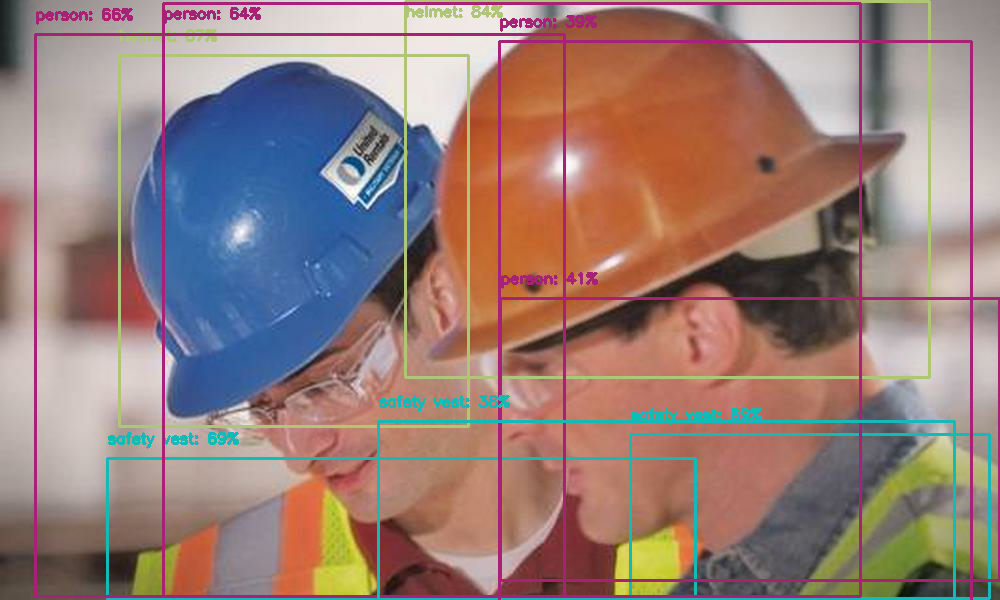

In [ ]:
# Input the image directory and location 
INPUT_IMAGE = '/content/TFlite/full/test/images/pos_125.jpg'
# Setting the minimum detection threshold
DETECTION_THRESHOLD = 0.3

#This script will resize an image (somepic.jpg) using PIL (Python Imaging Library) to a width of 300 pixels and a height proportional to the new width. It does this by determining what percentage 300 pixels is of the original width (img.size[0]) and then multiplying the original height (img.size[1]) by that percentage. Change "basewidth" to any other number to change the default width of your images.
basewidth = 1000
img = Image.open(INPUT_IMAGE)
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.ANTIALIAS)
img.save('/content/TFlite/full/test/images/temp_resize.jpg')

temp_file = '/content/TFlite/full/test/images/temp_resize.jpg'

# Run inference and draw detection result on the local copy of the original file
detection_result_image, results = run_odt_and_draw_results(
    temp_file, 
    interpreter, 
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)

In [ ]:
# zipping my TFlite folder for use to download and do analysis on the images in another colab notebook
!zip -r /content/TFlite.zip /content/TFlite

  adding: content/TFlite/ (stored 0%)
  adding: content/TFlite/full/ (stored 0%)
  adding: content/TFlite/full/val/ (stored 0%)
  adding: content/TFlite/full/val/images/ (stored 0%)
  adding: content/TFlite/full/val/images/pos_416.jpg (deflated 27%)
  adding: content/TFlite/full/val/images/pos_3452.jpg (deflated 1%)
  adding: content/TFlite/full/val/images/pos_23.jpg (deflated 1%)
  adding: content/TFlite/full/val/images/pos_3495.jpg (deflated 0%)
  adding: content/TFlite/full/val/images/pos_3522.jpg (deflated 3%)
  adding: content/TFlite/full/val/images/pos_1441.jpg (deflated 0%)
  adding: content/TFlite/full/val/images/pos_3485.jpg (deflated 3%)
  adding: content/TFlite/full/val/images/pos_65.jpg (deflated 9%)
  adding: content/TFlite/full/val/images/pos_31.jpg (deflated 17%)
  adding: content/TFlite/full/val/images/pos_3539.jpg (deflated 3%)
  adding: content/TFlite/full/val/images/pos_26.jpg (deflated 0%)
  adding: content/TFlite/full/val/images/pos_8.jpg (deflated 2%)
  adding: co